In [1]:
!pip install eli5 pandas-profiling==3.5.0 category_encoders xgboost plotly lightgbm imblearn pdpbox matplotlib shap
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost
import eli5


import warnings

from markupsafe import escape
from pandas_profiling import ProfileReport

from ipywidgets import interact, fixed

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, log_loss

from sklearn.inspection import permutation_importance

from eli5.sklearn import PermutationImportance

from imblearn.over_sampling  import *
from imblearn.under_sampling import *

from sklearn.model_selection import cross_val_score
warnings.filterwarnings(action='ignore')

import pandas_profiling

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.shape

(26457, 20)

In [5]:
# pr=train.profile_report() # 프로파일링 결과 리포트를 pr에 저장
# train.profile_report() # 바로 결과 보기
# train.profile_report()

# 가설
1. 신용거래 측정기준 - 신용거래기간
- 오랫동안 우량한 거래를 해온 사람이 갑자기 연체를 할 가능성이 낮다 -> 좋은신용평가를 가진다 
    
- 그에 비해 막 경제활동을 시작하는 20대 사회초년생은 긍정적으로 판단 할 정보가 없는 상황이므로 우량등급이 나오기 어렵다

2. 낮은 대출금리를 받기 위해서 높은 신용등급을 유지하는것이 좋다. 그렇다면 신용카드 발급일로부터 몇개월이 지나야 신용등급이 올라가는지 궁금.

# 변수 설명  
index  

gender : 성별  

car : 차량 소유 여부  

reality : 부동산 소유 여부  

child_num : 자녀 수  

income_total : 연간 소득  

income_type : 소득 분류  
- 'Commercial associate(금융관계자)', 'Working', 'State servant(공무원)', 'Pensioner(연금수령자)', 'Student'

edu_type : 교육 수준    
- 'Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree' 

family_type : 결혼 여부  
- 'Married', 'Civil marriage(사실혼)', 'Separated(별거)', 'Single / not married', 'Widow' 

house_type : 생활 방식  
- 'Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment'

DAYS_BIRTH : 출생일  
- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미  

DAYS_EMPLOYED : 업무 시작일  
- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
- 양수 값은 고용되지 않은 상태를 의미함  


FLAG_MOBIL : 핸드폰 소유 여부  

work_phone : 업무용 전화 소유 여부  

phone : 전화 소유 여부  

email : 이메일 소유 여부  

occyp_type : 직업 유형  	

family_size : 가족 규모 

begin_month : 신용카드 발급 월  
- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미      

credit : 사용자의 신용카드 대금 연체를 기준으로 한 신용도  
- 낮을 수록 높은 신용의 신용카드 사용자를 의미함  
- 0: 연체이력 없음, 신용도 높음
- 1: 연체이력 있음, 신용도 낮음



# 결측치 처리

In [6]:
df.info() # occyp_type 직업유형에 결측치 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [7]:
df['occyp_type'].fillna('Unknown', inplace=True)
df['occyp_type'].value_counts()

Unknown                  8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

# 중복값 처리
- df 데이터셋 중복값 없음


In [8]:
df.duplicated().sum() 

0

In [9]:
df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,Unknown,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,Unknown,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


# Feature Engineering
1. 의미없는 변수 제거
  - index 제거
  - FLAG_MOBIL 삭제:모든 값이 1로 동일
2.   "age" 컬럼 생성  
  -  DAYS_BIRTH 절댓값 -> 365로 나눈 몫 -> 나이를 나타냄  

3.   "career_yaer" 컬럼 생성

4. begin_month 
  - 절댓값 -> 신용카드 발급 후 몇 개월인지 나타냄

5. gender : 성별
  - M -> 0
  - W -> 1

6. car : 차량 소유 여부
  - N -> 0
  - Y -> 1
  
7. reality : 부동산 소유 여부  
  - N -> 0
  - Y -> 1 

8. 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    print(data['occyp_type'].value_counts(), '\n\n')  
    
9. family_size > 7 인 데이터 제거 

In [10]:
df.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [11]:
def findAge(days):
  return days // 365

In [12]:
df["DAYS_BIRTH"] = df["DAYS_BIRTH"].abs().apply(findAge)
df.rename(columns={'DAYS_BIRTH':'age'}, inplace=True)

In [13]:
df["age"]

0        38
1        31
2        52
3        41
4        41
         ..
26452    33
26453    41
26454    27
26455    27
26456    53
Name: age, Length: 26457, dtype: int64

In [14]:
df["DAYS_EMPLOYED"].value_counts()

 365243    4438
-401         57
-1539        47
-200         45
-2087        44
           ... 
-10475        1
-2202         1
-2552         1
-680          1
-4973         1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [15]:
 # 양수면 고용 되지 않은 상태 = 무직자 '0'으로 replace
df = df.replace({'DAYS_EMPLOYED':365243},0)
df["DAYS_EMPLOYED"].value_counts()

 0        4438
-401        57
-1539       47
-200        45
-2087       44
          ... 
-10475       1
-2202        1
-2552        1
-680         1
-4973        1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [16]:
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].abs().apply(findAge)
df.rename(columns={'DAYS_EMPLOYED':'career_year'}, inplace=True)

In [17]:
df["career_year"]
df["career_year"].value_counts()

0     6308
1     2340
3     2075
4     2049
2     2038
5     1541
6     1510
8     1332
7     1139
9      954
10     783
12     563
11     517
14     432
15     425
13     417
18     223
20     214
16     190
19     185
17     170
21     133
22     130
25     121
23     112
24      83
27      78
26      67
29      65
28      40
32      36
31      34
30      25
33      24
35      23
34      18
41      17
39      13
40      12
36      10
38       6
37       2
42       2
43       1
Name: career_year, dtype: int64

In [18]:
# # 로그 변환( 해야될까...?)
# train['career_year_log'] = train['career_year'].apply(np.log1p)
# train['career_year_log']

In [19]:
df["begin_month"] = df["begin_month"].abs()
df["begin_month"]

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

In [20]:
df['gender'] = df['gender'].replace(['F','M'],[0,1])

df['car'] = df['car'].replace(['N','Y'],[0,1])

df['reality'] = df['reality'].replace(['N','Y'],[0,1])

In [21]:
df['credit'] = df['credit'].replace(2,1)

In [22]:
 # 경력이 없고 직업군이 unknow인 사람은 no_work로 대체
df.loc[(df['career_year'] == 0) & (df['occyp_type'] == 'Unknown'), 'occyp_type'] = 'no_work'

print(df['occyp_type'].value_counts())

no_work                  4781
Laborers                 4512
Unknown                  3390
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64


In [23]:
df['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [24]:
df = df[(df['family_size'] <= 7)]
df = df.reset_index(drop=True)

In [25]:
df['family_size'].value_counts()

2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      291
6.0       44
7.0        9
Name: family_size, dtype: int64

In [26]:
# #  DAYS_BIRTH, DAYS_EMPLOYED, income_total변수를 조합하여 RATIO 변수 생성
# df['EMPLOYED_BIRTH_RATIO'] = df['career_year']/df['age']
# # tdfrain['INCOME_EMPLOYED_RATIO'] = df['income_total']/train['career_year']
# df['INCOME_BIRTH_RATIO'] = df['income_total']/df['age']

#     # 가족수 - 자식수
# train['diff_fam_child'] = train['family_size'] - train['child_num']
# test['diff_fam_child'] = test['family_size'] - test['child_num']



# #     # 가족수와 자녀수 sum 변수 추가
# # train['FAM_CHILD_SUM'] = train[['child_num', 'family_size']].sum(axis=1)
# # test['FAM_CHILD_SUM'] = test[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수 및 자식 수로 나눈 비율
df['INCOME_FAM_RATIO'] = df['income_total']/df['family_size']
# # train['INCOME_child_num_RATIO'] = train['income_total']/train['child_num']
    
#     # 일을하게 된 시점 변수 추가
# train['BIRTH_MINUS_EMPLOYED'] = train['age'] - train['career_year']
# test['BIRTH_MINUS_EMPLOYED'] = test['age'] - test['career_year']


In [27]:
# # income_total 변수 전처리

# # 로그 변환
# train['income_total_log'] = train['income_total'].apply(np.log1p)
# test['income_total_log'] = test['income_total'].apply(np.log1p)

In [28]:
# #float -> int
# train[['income_total', 'age', 'career_year', 'family_size', 'begin_month', 'EMPLOYED_BIRTH_RATIO', 'INCOME_EMPLOYED_RATIO', 'INCOME_BIRTH_RATIO', 'diff_fam_child', 'FAM_CHILD_SUM', 'INCOME_FAM_RATIO', 'INCOME_FAM_RATIO', 'BIRTH_MINUS_EMPLOYED', 'income_total_log']] = train[['income_total', 'age', 'career_year', 'family_size', 'begin_month', 'EMPLOYED_BIRTH_RATIO', 'INCOME_EMPLOYED_RATIO', 'INCOME_BIRTH_RATIO', 'diff_fam_child', 'FAM_CHILD_SUM', 'INCOME_FAM_RATIO', 'INCOME_FAM_RATIO', 'BIRTH_MINUS_EMPLOYED', 'income_total_log']].astype(int)

# feature간의 corr구해보기

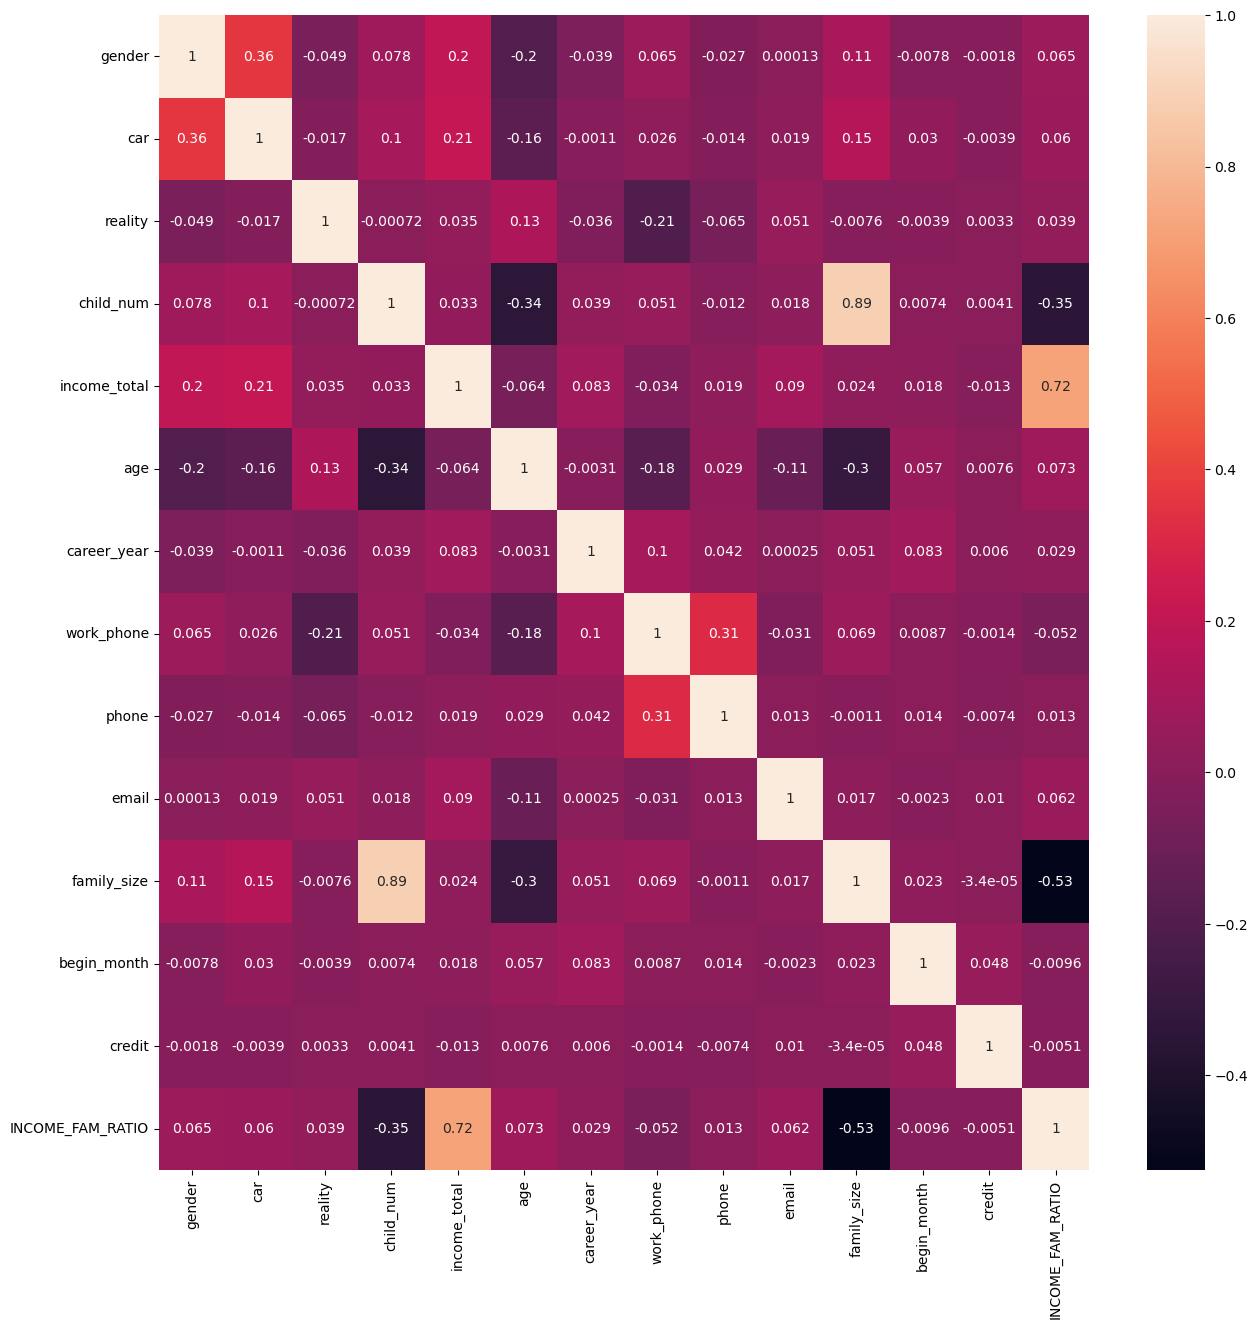

In [30]:
corr_matrix = df.corr()
plt.figure(figsize = (15,15))
sns_plot=sns.heatmap(corr_matrix,annot=True)
plt.show()

In [31]:
#credit과 corr 값 보기
df.corr().iloc[:,12].sort_values(ascending = False)

credit              1.000000
begin_month         0.048017
email               0.010101
age                 0.007642
career_year         0.006021
child_num           0.004052
reality             0.003301
family_size        -0.000034
work_phone         -0.001408
gender             -0.001795
car                -0.003939
INCOME_FAM_RATIO   -0.005115
phone              -0.007375
income_total       -0.012795
Name: credit, dtype: float64

# 데이터셋 분할

In [32]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split
target = 'credit'
features = df.drop(columns=target).columns

train, test = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target])
train, val = train_test_split(train, train_size=0.8, random_state=42, shuffle=True, stratify=train[target])

In [33]:
# 훈련/검증/테스트 데이터를 특성X과 타겟y으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

train.shape, val.shape, test.shape

((16928, 19), (4232, 19), (5291, 19))

# 각 cloumn 별 분포 확인


1. Target = credit 의 분포   
불균형한 데이터이기 때문에 모델링 할 때 유의해야함.

In [34]:
# 타겟 데이터 범주의 비율을 확인합니다.
y_train.value_counts(normalize=True)

1.0    0.87819
0.0    0.12181
Name: credit, dtype: float64

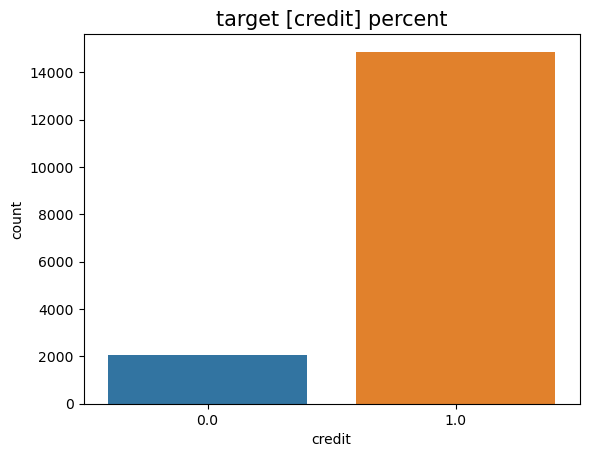

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=y_train);

plt.title('target [credit] percent', fontsize=15);

# 0: 높은 신용도, 연체이력 없음
# 1: 낮은 신용도, 연체이력 있음


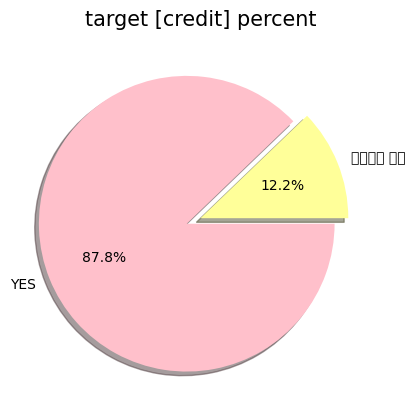

In [36]:
# Target value 시각화
ratio = df['credit'].value_counts(normalize=True)*100

ratio_ = [ratio[0], ratio[1]]
labels = ['연체이력 없음', 'YES']
explode = [0, 0.1]
plt.pie(ratio_, labels=labels, autopct='%.1f%%', explode=explode,
       shadow=True, colors=['#FFFF99', 'pink'])
plt.title('target [credit] percent', fontsize=15);

2. GENDER / OWN_CAR / OWN_REALITY

Text(0.5, 1.0, 'Distribution of email')

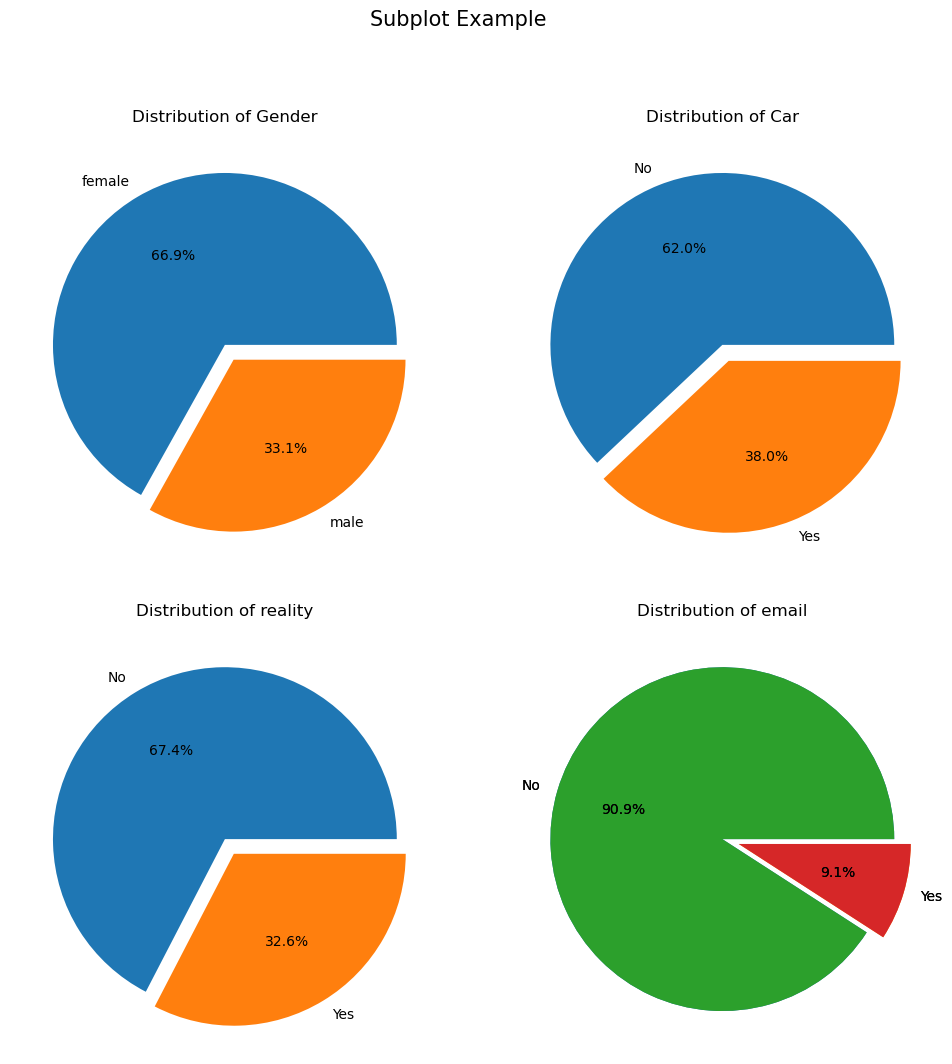

In [37]:
f, axes = plt.subplots(2, 2)
f.set_size_inches((12, 12))
plt.subplots_adjust(wspace = 0.15, hspace = 0.15)

# figure 전체 제목
f.suptitle('Subplot Example', fontsize = 15)

# gender
axes[0, 0].pie(df['gender'].value_counts(), explode=explode, autopct='%.1f%%', labels = ['female', 'male'])
axes[0, 0].set_title('Distribution of Gender', fontsize=12)

# car
axes[0, 1].pie(df['car'].value_counts(), explode=explode, autopct='%.1f%%', labels = ['No', 'Yes'])
axes[0, 1].set_title('Distribution of Car', fontsize=12)

# reality
axes[1, 0].pie(df['reality'].value_counts(), explode=explode, autopct='%.1f%%', labels = ['No', 'Yes'])
axes[1, 0].set_title('Distribution of reality', fontsize=12)

# email
axes[1, 1].pie(df['email'].value_counts(), explode=explode, autopct='%.1f%%', labels = ['No', 'Yes'])
axes[1, 1].set_title('Distribution of email', fontsize=12)

# work_phone
axes[1, 1].pie(df['email'].value_counts(), explode=explode, autopct='%.1f%%', labels = ['No', 'Yes'])
axes[1, 1].set_title('Distribution of email', fontsize=12)



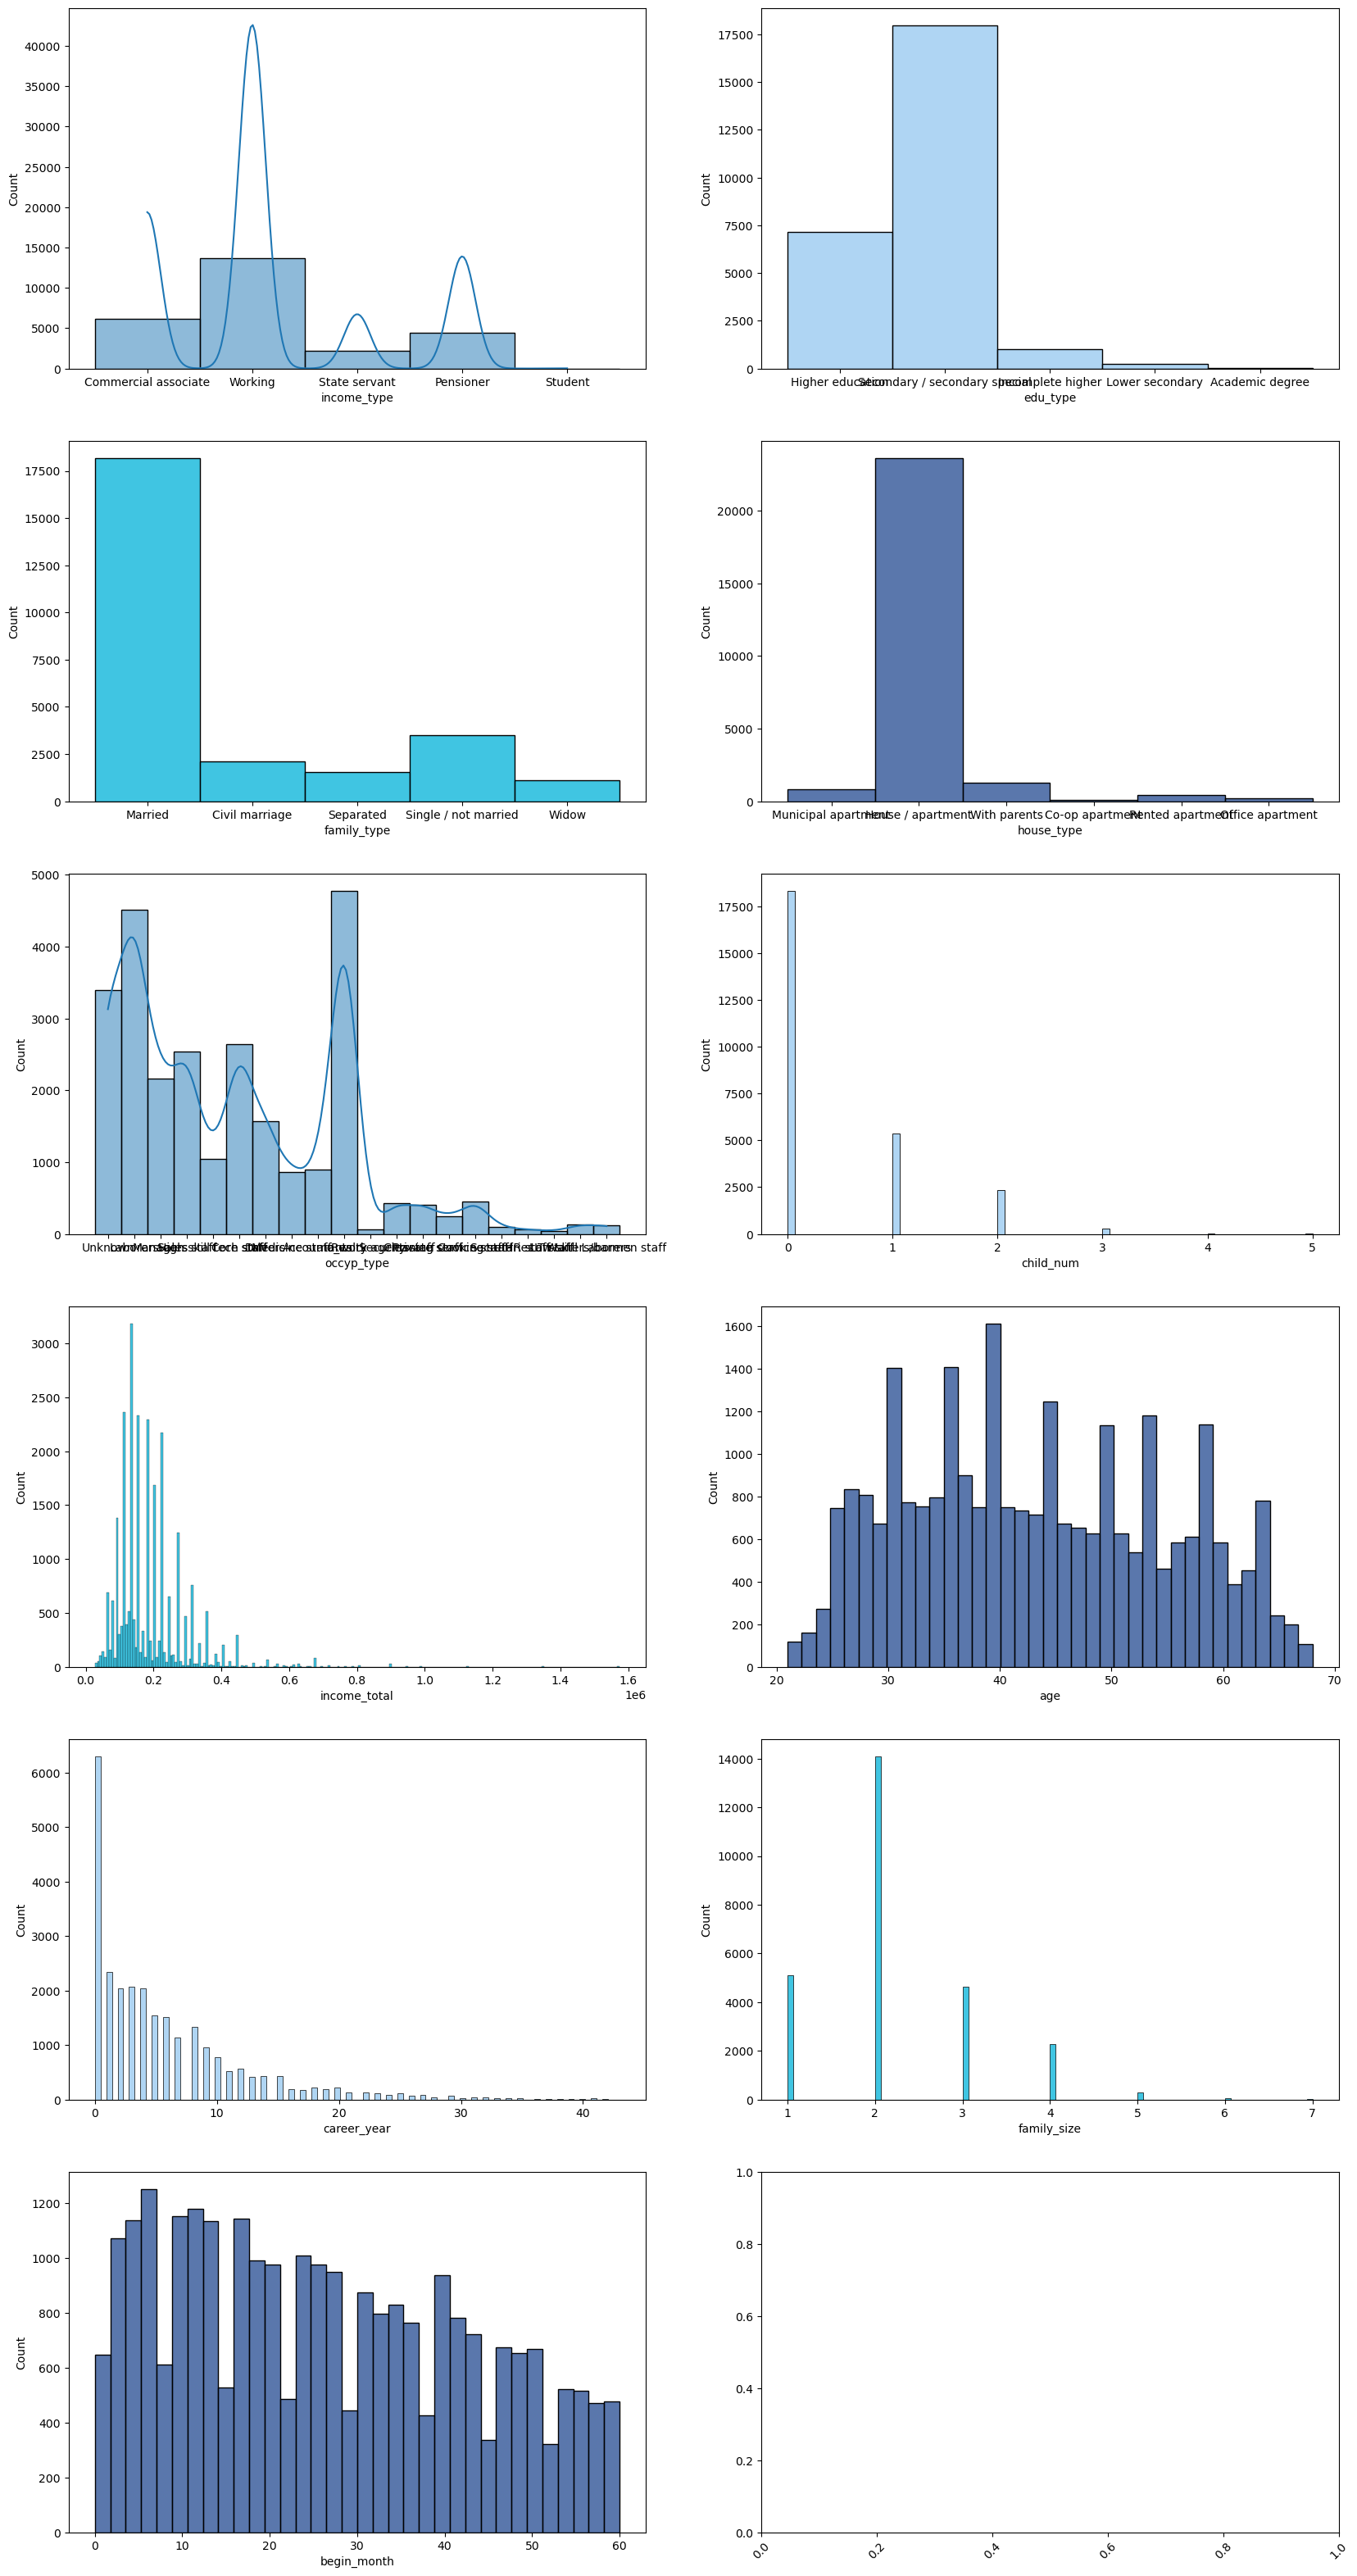

In [38]:
fig, axes = plt.subplots(6,2, figsize=(20,40))

hist1 = sns.histplot(data=df, x='income_type', ax=axes[0,0], kde=True);
hist2 = sns.histplot(data=df, x='edu_type', ax=axes[0,1], color='#95C8F0');
hist3 = sns.histplot(data=df, x='family_type', ax=axes[1,0], color='#00B2D9');
hist4 = sns.histplot(data=df, x='house_type', ax=axes[1,1], color='#234990');
hist5 = sns.histplot(data=df, x='occyp_type', ax=axes[2,0], kde=True);
hist6 = sns.histplot(data=df, x='child_num', ax=axes[2,1], color='#95C8F0');
hist7 = sns.histplot(data=df, x='income_total', ax=axes[3,0], color='#00B2D9');
hist8 = sns.histplot(data=df, x='age', ax=axes[3,1], color='#234990');
hist9 = sns.histplot(data=df, x='career_year', ax=axes[4,0], color='#95C8F0');
hist10 = sns.histplot(data=df, x='family_size', ax=axes[4,1], color='#00B2D9');
hist11= sns.histplot(data=df, x='begin_month', ax=axes[5,0], color='#234990');
plt.xticks(rotation=45);

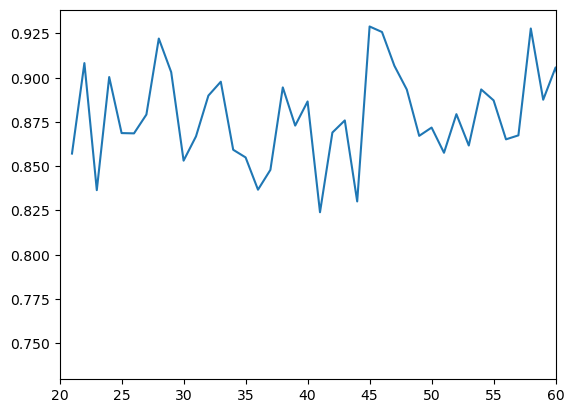

In [39]:
import matplotlib.pyplot as plt
data = df.groupby('age')['credit'].mean()
data

x = data.index.tolist()
y = data
plt.xlim(20,60)
plt.plot(x, y)

plt.show()

In [40]:
import matplotlib.pyplot as plt
data = df.groupby('begin_month')['credit'].mean()
data

begin_month
0.0     0.640693
1.0     0.768675
2.0     0.817992
3.0     0.816189
4.0     0.865350
          ...   
56.0    0.866142
57.0    0.903509
58.0    0.897119
59.0    0.913223
60.0    0.906383
Name: credit, Length: 61, dtype: float64

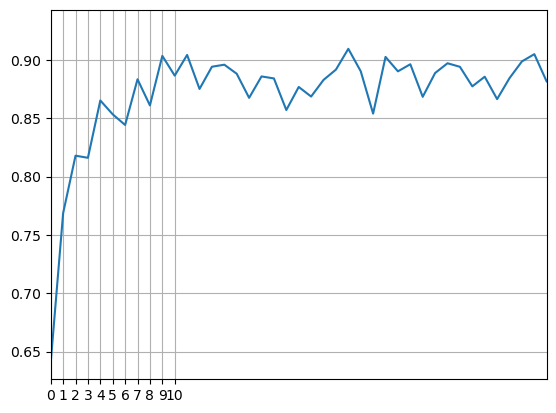

In [41]:
data = df.groupby('begin_month')['credit'].mean()
x = data.index.tolist()
y = data

plt.xlim(0, 40)
plt.xticks(range(11))
plt.grid()

plt.plot(x, y)

plt.show()

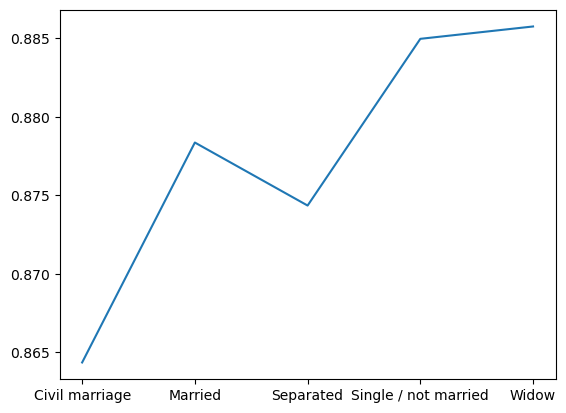

In [42]:

data = df.groupby('family_type')['credit'].mean()

x = data.index.tolist()
y = data



plt.plot(x, y)

plt.show()

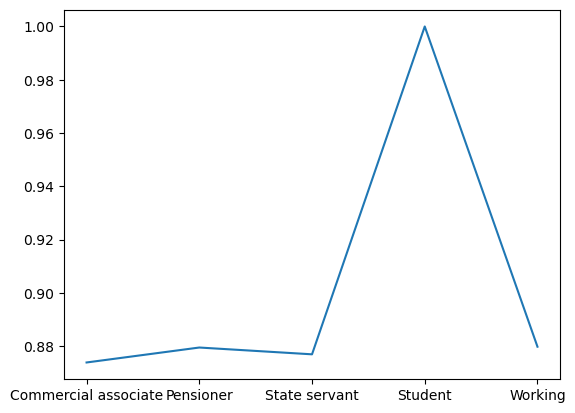

In [43]:

data = df.groupby('income_type')['credit'].mean()

x = data.index.tolist()
y = data



plt.plot(x, y)

plt.show()

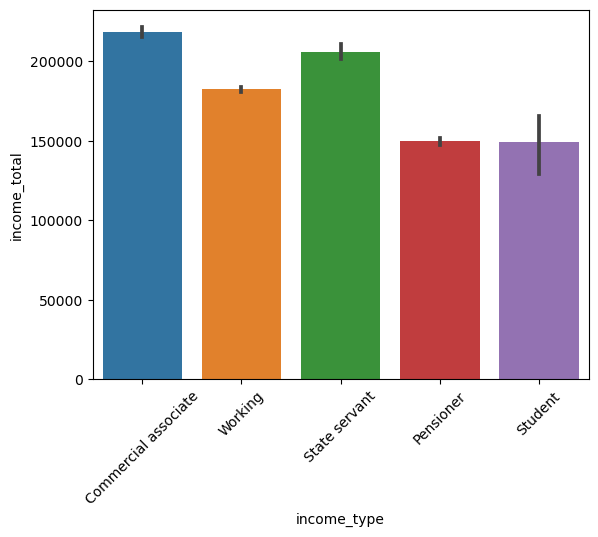

In [44]:
# 학생이 총 수입이 적고
sns.barplot(x='income_type', y='income_total', data=df)
plt.xticks(rotation=45);

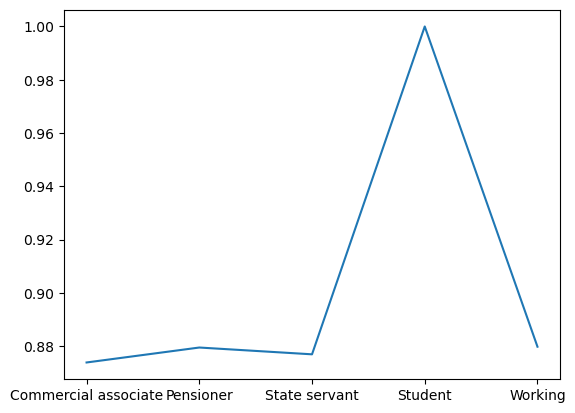

In [45]:
data = df.groupby('income_type')['credit'].mean()
x = data.index.tolist()
y = data

plt.plot(x, y)

plt.show()

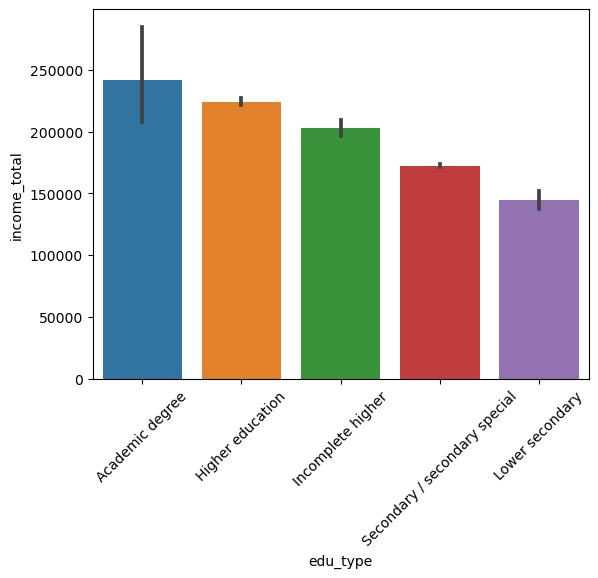

In [46]:
# qualitative_colors = sns.color_palette("Set3", 10)
# sns.palplot(qualitative_colors)

sns.barplot(x='edu_type', y='income_total', data=df, 
            order = ['Academic degree', 'Higher education', 'Incomplete higher',
                            'Secondary / secondary special', 'Lower secondary'])
plt.xticks(rotation=45);

<AxesSubplot: xlabel='family_type', ylabel='income_total'>

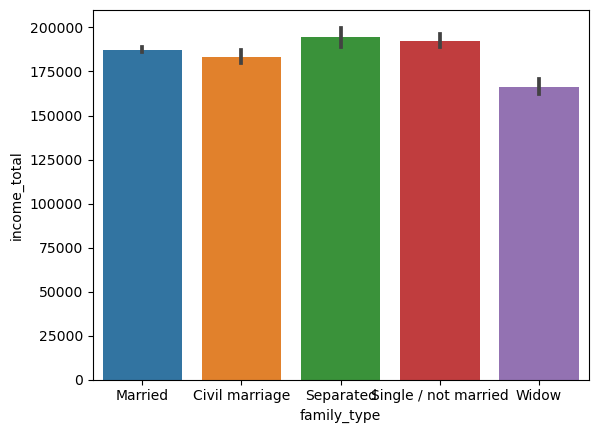

In [47]:
sns.barplot(x='family_type', y='income_total', data=df)

# 기준모델
- 분류에서는 타겟의 최빈값 사용



In [48]:
# 기준모델 
df[target].value_counts(normalize=True).max()

0.8781898604967676

- imbalanced data 타겟의 클래스가 불균형함


문제:  데이터의 수가 많은 class1로 치우치게 예측 하도록 학습됨

In [49]:
# mode(): Return the highest frequency value in a Series.
major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만듭니다. 기준모델로 타겟인 credit 값을 전부 0으로 찍는 모델이다.)
y_pred = [major] * len(y_train)

In [50]:
# 최다 클래스의 빈도가 정확도가 됩니다. 
from sklearn.metrics import accuracy_score
print("training accuracy: ", round(accuracy_score(y_train, y_pred), 2))

training accuracy:  0.88


In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix

In [52]:
# 검증세트 에서도 정확도를 확인해 볼 수 있습니다.
y_val = val[target]
y_pred = [major] * len(y_val)
print("validation accuracy: ", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

validation accuracy:  0.8780718336483931
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       516
         1.0       0.88      1.00      0.94      3716

    accuracy                           0.88      4232
   macro avg       0.44      0.50      0.47      4232
weighted avg       0.77      0.88      0.82      4232



- 정확도인 accuracy는 0.88로 높은 반면 target인 0에 대해서는 전혀 예측하지 못하는 모델이다.
- 따라서 분류모델의 성능을 평가하는 지표를 f1-score를 이용해서 정밀도(precision)과 재현율(recall)을 살펴 보아야 한다.

# 1. RandomForest 
- 앙상블모델 -> 배깅 사용   


In [53]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score

In [54]:
# RandomForest 파이프라인
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  0.9909026465028355
검증 정확도:  0.8761814744801513


- 훈련 정확도가 거의 100% 가깝고, 그에 비해 검증정확도는 낮음 -> 과적합 발생

In [55]:
%%time
pipe_2 = make_pipeline(OrdinalEncoder(),
                    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs = -1))

#RandomizedSearchCV를 이용해서 각 하이퍼 파라미터에 대해서 학습을 할 범위를 정해준다.
dists_2= {'randomforestclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
         'randomforestclassifier__n_estimators': randint(50, 100), #몇개의 결정트리 모델을 만들어서 랜덤 포레스트 모델을 만들지 결정하는 하이퍼 파라미터이다.
         'randomforestclassifier__max_depth': [5, 10, 15, 20, None], #몇번의 분기를 거쳐서 분류하는 결정트리 모델을 만들 것인지 결정하는 하이퍼 파라미터이다.
         'randomforestclassifier__min_samples_split' : randint(10, 100),
         'randomforestclassifier__min_samples_leaf' : randint(10, 100),
         'randomforestclassifier__max_features' : ['sqrt', 'log2', None]
}


#randomized Search CV 진행조건을 설정해준다.
clf_2 = RandomizedSearchCV(
    pipe_2, #파이프라인으로 학습된 모델
    param_distributions = dists_2, #하이퍼파라미터 튜닝 값으로 진행한다.
    n_iter = 10, # 반복 횟수
    cv = 3, # 교차검증 횟수 (==> n_iter * cv 의 숫자만큼 진행됨)
    scoring = 'f1',  # 오차 평가방법
    verbose = 1,# 훈련 중지여부를 화면에 출력 (1= progress bar/2= one line per epoch)
    n_jobs = -1, #컴퓨터의 모든 가용 자원을 이용해서 학습을 진행하라는 코드이다.
)

#randomized Search CV로 train data 학습 진행
clf_2.fit(X_train, y_train);


Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 2.73 s, sys: 185 ms, total: 2.92 s
Wall time: 4.46 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
                                        'randomfor...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b882d9f0>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b781a4d0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b882cd00>},
                   scoring='f1', verbose=1)

# 최적의 하이퍼파라미터를 적용한 랜덤포레스트

In [56]:
print('최적 하이퍼파라미터: ', clf_2.best_params_)
print('accuracy: ', clf_2.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 46, 'randomforestclassifier__min_samples_split': 69, 'randomforestclassifier__n_estimators': 55}
accuracy:  0.8700121955606561


In [57]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
best_model_rf = clf_2.best_estimator_

y_pred_train = best_model_rf.predict(X_train)
y_pred_val = best_model_rf.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.839851134215501
검증 정확도:  0.7901701323251418
              precision    recall  f1-score   support

         0.0       0.25      0.35      0.29       516
         1.0       0.90      0.85      0.88      3716

    accuracy                           0.79      4232
   macro avg       0.58      0.60      0.58      4232
weighted avg       0.82      0.79      0.81      4232



In [58]:
# 연체이력 없을 확률 -> 0 
y_pred_proba = clf_2.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.56637103, 0.47430891, 0.30899517, ..., 0.62097722, 0.65174321,
       0.65497331])

In [59]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc


,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.854137
1,0.000000,0.000269,0.854137
2,0.000000,0.002422,0.815772
3,0.001938,0.002422,0.813567
4,0.001938,0.005651,0.797540
...,...,...,...
979,0.996124,0.997578,0.234727
980,0.998062,0.997578,0.232309
981,0.998062,0.999462,0.210503
982,1.000000,0.999462,0.206708


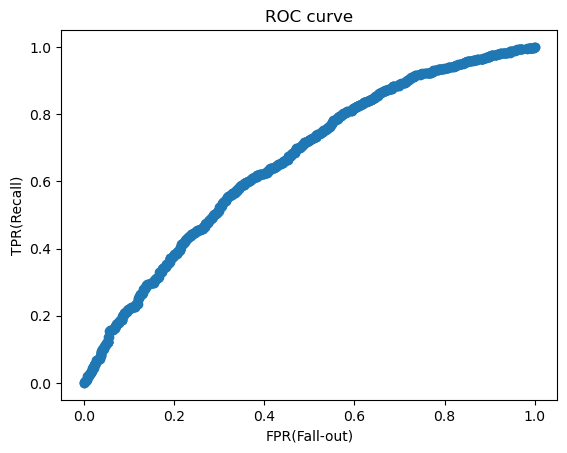

In [60]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [61]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score
print('AUC score: ', auc_score)

AUC score:  0.6604331468362248


# 2. XGBoost

- 과적합 제어 방법
  - learning rate(0.01 ~ 0.1) → learning rate 값을 낮추면 n_estimator를 반대로 높여주어야 합니다.
  - max_depth 값을 낮춥니다.
  - min_child_weight 값을 높입니다.
  - min_split_loss 값을 높입니다.
  - subsample과 colsample_bytree를 낮춥니다.

※ Early Stopping 기능 :  
GBM의 경우 n_estimators에 지정된 횟수만큼 학습을 끝까지 수행하지만, XGB의 경우 오류가 더 이상 개선되지 않으면 수행을 중지  
n_estimators 를 200으로 설정하고, 조기 중단 파라미터 값을 50으로 설정하면, 1부터 200회까지 부스팅을 반복하다가 50회를 반복하는 동안 학습오류가 감소하지 않으면 더 이상 부스팅을 진행하지 않고 종료합니다.  
(가령 100회에서 학습오류 값이 0.8인데 101~150회 반복하는 동안 예측 오류가 0.8보다 작은 값이 하나도 없으면 부스팅을 종료)

In [62]:
%%time
pipe = make_pipeline(OrdinalEncoder(),
                    XGBClassifier(random_state=42, n_jobs = -1))

dist_xgb = {
    'xgbclassifier__learning_rate' : [0.1, 0.07, 0.04, 0.01],
    'xgbclassifier__n_estimators' : randint(10, 1000),
    'xgbclassifier__max_depth' : randint(5, 100),
    'xgbclassifier__scale_pos_weight' : [1, 2, 3, 4, 5] # 타겟 class 불균형 때문에 사용.
}
    

clf_xgb = RandomizedSearchCV(pipe,
                        param_distributions = dist_xgb,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,  
                        n_jobs = -1)

clf_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1.67 s, sys: 17.7 ms, total: 1.69 s
Wall time: 54.4 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy...
                   param_distributions={'xgbclassifier__learning_rate': [0.1,
                                                                         0.07,
                                                                         0.04,
                                                                         0.01],
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b8675cc0>,
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b870b4f0>,
                                        'xgbclassifier__scale_pos_weight': [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5]},
                   random_state=42, scoring='f1', verbose=1)

In [63]:
print('최적 하이퍼파라미터: ', clf_xgb.best_params_)
print('accuracy: ', clf_xgb.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 62, 'xgbclassifier__n_estimators': 31, 'xgbclassifier__scale_pos_weight': 5}
accuracy:  0.9349863914420035


In [64]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
best_model_xgb = clf_xgb.best_estimator_

y_pred_train = best_model_xgb.predict(X_train)
y_pred_val = best_model_xgb.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.8796668241965974
검증 정확도:  0.8775992438563327
              precision    recall  f1-score   support

         0.0       0.25      0.00      0.00       516
         1.0       0.88      1.00      0.93      3716

    accuracy                           0.88      4232
   macro avg       0.56      0.50      0.47      4232
weighted avg       0.80      0.88      0.82      4232



# early_stopping_rounds를 이용해서 과적합이 줄어든 모델을 만들어 본다.

In [65]:
#인코더를 거친 데이터를 만든다.
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators = 1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth = 11,       
    learning_rate = 0.3, 
    scale_pos_weight = 1.2, # imbalance 데이터 일 경우 비율을 적용한니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 30 # 30 rounds 동안 스코어의 개선이 없으면 멈춤
         )

[0]	validation_0-error:0.11508	validation_1-error:0.12595
[1]	validation_0-error:0.11596	validation_1-error:0.12405
[2]	validation_0-error:0.11478	validation_1-error:0.12169
[3]	validation_0-error:0.11454	validation_1-error:0.12216
[4]	validation_0-error:0.11348	validation_1-error:0.12169
[5]	validation_0-error:0.11236	validation_1-error:0.12146
[6]	validation_0-error:0.11189	validation_1-error:0.12004
[7]	validation_0-error:0.11065	validation_1-error:0.11933
[8]	validation_0-error:0.10958	validation_1-error:0.12004
[9]	validation_0-error:0.10852	validation_1-error:0.11933
[10]	validation_0-error:0.10710	validation_1-error:0.11933
[11]	validation_0-error:0.10403	validation_1-error:0.12004
[12]	validation_0-error:0.10226	validation_1-error:0.11933
[13]	validation_0-error:0.09966	validation_1-error:0.11933
[14]	validation_0-error:0.09789	validation_1-error:0.11862
[15]	validation_0-error:0.09729	validation_1-error:0.11862
[16]	validation_0-error:0.09576	validation_1-error:0.11957
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=11, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [66]:
print('훈련 정확도: ', model.score(X_train_encoded, y_train))
print('검증 정확도: ', model.score(X_val_encoded, y_val))

print(classification_report(y_val, model.predict(X_val_encoded)))

훈련 정확도:  0.9021148393194707
검증 정확도:  0.8813799621928167
              precision    recall  f1-score   support

         0.0       0.65      0.06      0.11       516
         1.0       0.88      1.00      0.94      3716

    accuracy                           0.88      4232
   macro avg       0.76      0.53      0.52      4232
weighted avg       0.86      0.88      0.84      4232



# 4. LightGBM

- 과적합 줄이는 방법
  - max_bin 작게
  - num_leaves = max_leaves 작게
  - mean_data_in_leaf 사용
  - min_sum_hessian_in_leaf 사용

In [67]:
pipe = make_pipeline(OrdinalEncoder(),
                    LGBMClassifier(random_state=42, boost_from_average=False))

dist_lgbm = {
    'lgbmclassifier__learning_rate' :  [0.1, 0.07, 0.04, 0.01],
    'lgbmclassifier__n_estimators' : randint(10, 1000),
    'lgbmclassifier__min_data_in_leaf ' : randint(10, 100),
    'lgbmclassifier__max_depth' : randint(5, 50),
    'lgbmclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf_lgbm = RandomizedSearchCV(pipe,
                        param_distributions = dist_lgbm,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: 92
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier(boost_from_average=False,
                                                             random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.1,
                                                                          0.07,
                                                                          0.04,
                                                                          0.01],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b772e650>,
                                        'lgbmclassifier__min_data_in_leaf ': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b772e6e0>,
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b87096f0>,
                                        'lgbmclassifier__scale_pos_weight': [1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5]},
                   random_state=42, scoring='f1', verbose=1)

In [68]:
pd.DataFrame(clf_lgbm.cv_results_).sort_values(by='rank_test_score').T


,1,5,7,0,2,9,4,6,3,8
mean_fit_time,0.519708,1.149012,1.34446,0.354825,0.349607,0.717236,1.080927,1.763451,1.568008,0.801226
std_fit_time,0.009814,0.023807,0.039348,0.008677,0.023185,0.017545,0.023451,0.087089,0.020251,0.03134
mean_score_time,0.088901,0.224136,0.307642,0.05682,0.065836,0.096729,0.176493,0.440345,0.464095,0.12892
std_score_time,0.000129,0.018703,0.05932,0.001702,0.002605,0.010696,0.011242,0.018673,0.023638,0.013486
param_lgbmclassifier__learning_rate,0.1,0.07,0.01,0.04,0.04,0.01,0.01,0.04,0.07,0.1
param_lgbmclassifier__max_depth,43,48,7,33,28,18,25,46,28,43
param_lgbmclassifier__min_data_in_leaf,92,98,60,24,33,18,42,69,39,27
param_lgbmclassifier__n_estimators,224,570,656,116,140,355,469,985,815,397
param_lgbmclassifier__scale_pos_weight,3,3,5,5,5,5,2,3,2,1
params,"{'lgbmclassifier__learning_rate': 0.1, 'lgbmcl...","{'lgbmclassifier__learning_rate': 0.07, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.01, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.04, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.04, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.01, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.01, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.04, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.07, 'lgbmc...","{'lgbmclassifier__learning_rate': 0.1, 'lgbmcl..."


In [69]:
best_model_lgbm = clf_lgbm.best_estimator_

y_pred_train = best_model_lgbm.predict(X_train)
y_pred_val = best_model_lgbm.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.8898865784499055
검증 정확도:  0.8809073724007561
              precision    recall  f1-score   support

         0.0       0.80      0.03      0.06       516
         1.0       0.88      1.00      0.94      3716

    accuracy                           0.88      4232
   macro avg       0.84      0.51      0.50      4232
weighted avg       0.87      0.88      0.83      4232



In [70]:
y_pred_proba = clf_lgbm.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.96633472, 0.90374661, 0.9674623 , ..., 0.98112073, 0.9539824 ,
       0.97000486])

In [71]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.998726
1,0.000000,0.000269,0.998726
2,0.000000,0.005920,0.996570
3,0.001938,0.005920,0.996565
4,0.001938,0.007804,0.996180
...,...,...,...
975,0.992248,0.999462,0.332395
976,0.992248,0.999731,0.318308
977,0.996124,0.999731,0.205372
978,0.996124,1.000000,0.197065


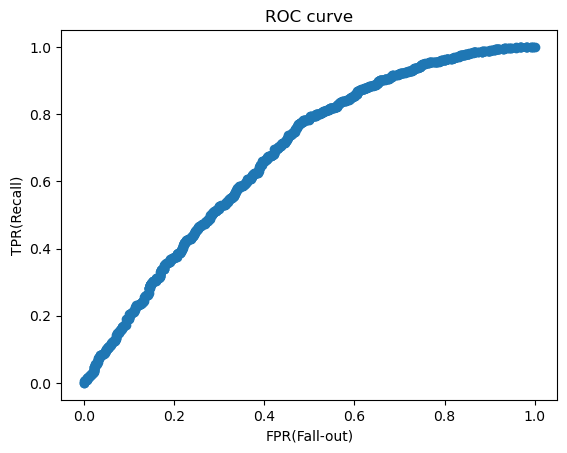

In [72]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

정밀도 : 예측한 것중에 정답의 비율은?

재현율 : 찾아야 할 것중에 실제로 찾은 비율은?

F1 Score : 정밀도와 재현율의 평균

이중에서 F1 Score 값이 높으면 성능이 높다

In [73]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score
print('AUC score: ', auc_score)

AUC score:  0.678125078228653


In [74]:
confusion_matrix(y_val, y_pred_val)

array([[  16,  500],
       [   4, 3712]])

# 오버샘플링 후 모델링
- 일반적으로, 분류 문제에서 target 변수(Y)의 클래스들이 imbalanced한 문제를 해결하기 위해 샘플링을 진행한다. 샘플링 기법에는 undersampling 과 oversampling이 있는데, undersampling은 많은 데이터 수를 삭제하므로 데이터의 수가 부족해지는 문제점이 발생한다. 따라서 나는 oversampling을 진행하였다.

- ADASYN
  - 이 방법은 SMOTE와 유사하지만 오버샘플링할 클래스의 로컬 분포 추정값에 따라 다른 수의 샘플을 생성한다.


In [75]:
# ADASYN 는 숫자형만 받아들이기 때문에 카테고리 형을 인코딩해준다.
train1 = train.copy()
val1 = val.copy()
test1 = test.copy()

enc = OrdinalEncoder()

enc.fit(train1)
train1 = enc.transform(train1)

enc.fit(val1)
val1 = enc.transform(val1)

enc.fit(test1)
test1 = enc.transform(test1)     

In [76]:
train1

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,age,career_year,work_phone,phone,email,occyp_type,family_size,begin_month,credit,INCOME_FAM_RATIO
23238,0,0,1,0,202500.0,1,1,1,1,59,0,0,0,0,1,1.0,30.0,1.0,202500.00
3230,0,1,0,0,135000.0,2,1,2,1,28,0,0,0,0,2,2.0,34.0,1.0,67500.00
12270,1,1,1,1,112500.0,3,1,2,1,34,1,1,0,1,3,3.0,34.0,1.0,37500.00
4982,1,0,0,0,190399.5,2,1,2,1,28,3,1,0,0,4,2.0,11.0,1.0,95199.75
20234,1,1,0,0,256500.0,1,2,2,1,60,0,0,1,0,1,2.0,16.0,1.0,128250.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11394,0,0,0,1,108000.0,3,1,4,1,39,11,0,1,0,5,2.0,11.0,1.0,54000.00
20702,0,1,0,3,675000.0,3,1,2,1,37,5,0,0,0,6,5.0,37.0,1.0,135000.00
8514,1,1,1,2,225000.0,2,1,5,1,50,11,1,1,1,5,4.0,38.0,1.0,56250.00
18443,0,0,1,1,180000.0,3,2,4,1,45,6,0,0,1,5,2.0,16.0,1.0,90000.00


In [77]:
X_train = train1[features]
y_train = train1[target]

X_val = val1[features]
y_val = val1[target]

X_test = test1[features]
y_test = test1[target]


In [78]:
# ADASYN을 이용한 sampling
from imblearn.over_sampling import ADASYN 
ada = ADASYN(random_state=42, sampling_strategy='all') 

X_train_os, y_train_os = ada.fit_resample(X_train, y_train)
print(y_train_os.value_counts())

X_val_os, y_val_os = ada.fit_resample(X_val, y_val)
print(y_val_os.value_counts())

X_test_os, y_test_os = ada.fit_resample(X_test, y_test)
print(y_test_os.value_counts())

0.0    15155
1.0    14866
Name: credit, dtype: int64
1.0    3716
0.0    3648
Name: credit, dtype: int64
1.0    4647
0.0    4558
Name: credit, dtype: int64


# RandomForest


In [79]:
%%time
pipe_rf = make_pipeline(OrdinalEncoder(),
                    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs = -1))

#RandomizedSearchCV를 이용해서 각 하이퍼 파라미터에 대해서 학습을 할 범위를 정해준다.
dists_rf = {'randomforestclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
         'randomforestclassifier__n_estimators': randint(50, 100), #몇개의 결정트리 모델을 만들어서 랜덤 포레스트 모델을 만들지 결정하는 하이퍼 파라미터이다.
         'randomforestclassifier__max_depth': [5, 10, 15, 20, None], #몇번의 분기를 거쳐서 분류하는 결정트리 모델을 만들 것인지 결정하는 하이퍼 파라미터이다.
         'randomforestclassifier__min_samples_split' : randint(10, 100),
         'randomforestclassifier__min_samples_leaf' : randint(10, 100),
         'randomforestclassifier__max_features' : ['sqrt', 'log2', None]
}


#randomized Search CV 진행조건을 설정해준다.
clf_rf = RandomizedSearchCV(
    pipe_rf, #파이프라인으로 학습된 모델
    param_distributions = dists_rf, #하이퍼파라미터 튜닝 값으로 진행한다.
    n_iter = 10, # 반복 횟수
    cv = 3, # 교차검증 횟수 (==> n_iter * cv 의 숫자만큼 진행됨)
    scoring = 'f1',  # 오차 평가방법
    verbose = 1,# 훈련 중지여부를 화면에 출력 (1= progress bar/2= one line per epoch)
    n_jobs = -1, #컴퓨터의 모든 가용 자원을 이용해서 학습을 진행하라는 코드이다.
)

#randomized Search CV로 train data 학습 진행
clf_rf.fit(X_train_os, y_train_os);


Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 4.76 s, sys: 279 ms, total: 5.04 s
Wall time: 4.07 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
                                        'randomfor...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cc53be0>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb3b7663be0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cc51a20>},
                   scoring='f1', verbose=1)

In [80]:
best_model_rf_sammpling = clf_rf.best_estimator_

y_pred_train = best_model_rf_sammpling.predict(X_train_os)
y_pred_val = best_model_rf_sammpling.predict(X_val_os)

print('훈련 정확도: ', accuracy_score(y_train_os, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_os, y_pred_val))
print(classification_report(y_val_os, y_pred_val, digits=4))

훈련 정확도:  0.8057026747943107
검증 정확도:  0.6979902227050516
              precision    recall  f1-score   support

         0.0     0.6926    0.7018    0.6972      3648
         1.0     0.7034    0.6943    0.6988      3716

    accuracy                         0.6980      7364
   macro avg     0.6980    0.6980    0.6980      7364
weighted avg     0.6981    0.6980    0.6980      7364



In [81]:
# 연체이력 없을 확률 -> 0
y_pred_proba = clf_rf.predict_proba(X_val_os)[:, 1]
y_pred_proba

array([0.13373824, 0.74582361, 0.38541587, ..., 0.29207262, 0.2006269 ,
       0.43689813])

In [82]:

# y_pred_proba = pipe_rf.predict_proba(X_val_os)[:, 1]
# y_pred_proba

In [83]:
# roc_curve(타겟값, prob of 0)
fpr, tpr, thresholds = roc_curve(y_val_os, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.889970
1,0.000000,0.000269,0.889970
2,0.000000,0.000538,0.880417
3,0.000274,0.000538,0.868926
4,0.000274,0.010226,0.830400
...,...,...,...
3179,0.994792,1.000000,0.054496
3180,0.995340,1.000000,0.053575
3181,0.995614,1.000000,0.053318
3182,0.996162,1.000000,0.053192


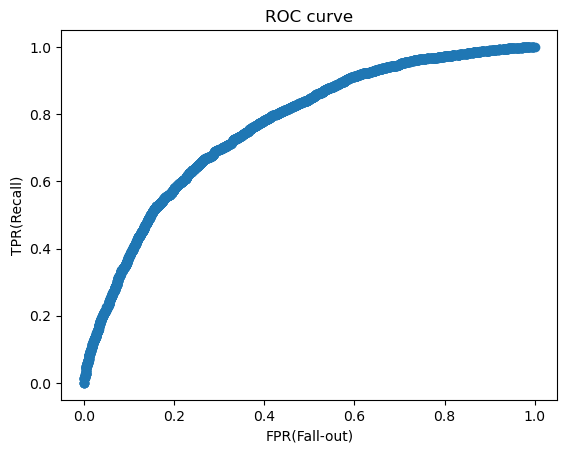

In [84]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [85]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val_os, y_pred_proba)
auc_score

0.7651477563240043

# XGBoost

In [86]:
%%time
pipe_xgb = make_pipeline(OrdinalEncoder(),
                    XGBClassifier(random_state=42, n_jobs = -1))

dist_xgb = {
    'xgbclassifier__learning_rate' : [0.1, 0.07, 0.04, 0.01],
    'xgbclassifier__n_estimators' : randint(10, 1000),
    'xgbclassifier__max_depth' : randint(5, 100),
    'xgbclassifier__scale_pos_weight' : [1, 2, 3, 4, 5] # 타겟 class 불균형 때문에 사용.
}
    

clf_xgb = RandomizedSearchCV(pipe_xgb,
                        param_distributions = dist_xgb,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,  
                        n_jobs = -1)

clf_xgb.fit(X_train_os, y_train_os)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: 39
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 98
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 18
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 33
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 69
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 24
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Curren

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy...
                   param_distributions={'xgbclassifier__learning_rate': [0.1,
                                                                         0.07,
                                                                         0.04,
                                                                         0.01],
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cd2f580>,
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cd2dd20>,
                                        'xgbclassifier__scale_pos_weight': [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5]},
                   random_state=42, scoring='f1', verbose=1)

In [87]:
best_model_xgb_sammpling = clf_xgb.best_estimator_

y_pred_train = best_model_xgb_sammpling.predict(X_train_os)
y_pred_val = best_model_xgb_sammpling.predict(X_val_os)

print('훈련 정확도: ', accuracy_score(y_train_os, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_os, y_pred_val))
print(classification_report(y_val_os, y_pred_val, digits=4))

훈련 정확도:  0.9948036374537823
검증 정확도:  0.8174904942965779
              precision    recall  f1-score   support

         0.0     0.8384    0.7823    0.8094      3648
         1.0     0.7995    0.8520    0.8249      3716

    accuracy                         0.8175      7364
   macro avg     0.8190    0.8172    0.8172      7364
weighted avg     0.8188    0.8175    0.8172      7364



In [88]:
# 연체이력 없을 확률 -> 0 
y_pred_proba = clf_xgb.predict_proba(X_val_os)[:, 1]
y_pred_proba

array([0.75952655, 0.98889333, 0.80544096, ..., 0.00393651, 0.00223693,
       0.47322288], dtype=float32)

In [89]:
# roc_curve(타겟값, prob of 0)
fpr, tpr, thresholds = roc_curve(y_val_os, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.999876
1,0.000000,0.000269,0.999876
2,0.000000,0.001346,0.999796
3,0.000274,0.001346,0.999793
4,0.000274,0.001884,0.999768
...,...,...,...
2049,0.989583,1.000000,0.000105
2050,0.990132,1.000000,0.000105
2051,0.992325,1.000000,0.000090
2052,0.992873,1.000000,0.000088


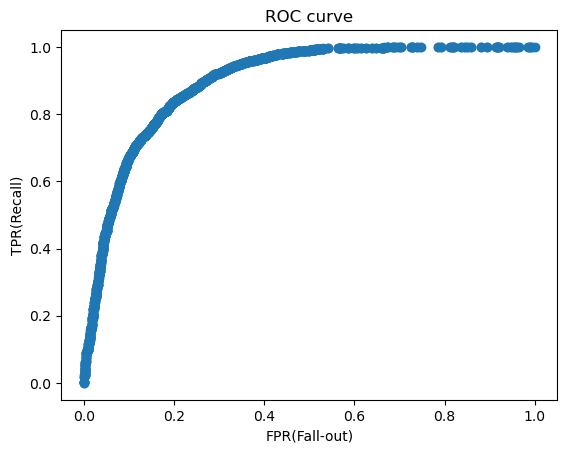

In [90]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [91]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val_os, y_pred_proba)
auc_score

0.8972508270895889

# LightGBM

In [92]:
%%time
pipe = make_pipeline(OrdinalEncoder(),
                    LGBMClassifier(random_state=42, boost_from_average=False))

dist_lgbm = {
    'lgbmclassifier__learning_rate' :  [0.1, 0.07, 0.04, 0.01],
    'lgbmclassifier__n_estimators' : randint(10, 1000),
    'lgbmclassifier__min_data_in_leaf ' : randint(10, 100),
    'lgbmclassifier__max_depth' : randint(5, 50),
    'lgbmclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf_lgbm = RandomizedSearchCV(pipe,
                        param_distributions = dist_lgbm,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf_lgbm.fit(X_train_os, y_train_os)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: 39
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
CPU times: user 14.3 s, sys: 149 ms, total: 14.4 s
Wall time: 5.72 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier(boost_from_average=False,
                                                             random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.1,
                                                                          0.07,
                                                                          0.04,
                                                                          0.01],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cb46530>,
                                        'lgbmclassifier__min_data_in_leaf ': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cb47eb0>,
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb46cb46650>,
                                        'lgbmclassifier__scale_pos_weight': [1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5]},
                   random_state=42, scoring='f1', verbose=1)

In [93]:
best_model_lgbm_sammpling = clf_lgbm.best_estimator_

y_pred_train = best_model_lgbm_sammpling.predict(X_train_os)
y_pred_val = best_model_lgbm_sammpling.predict(X_val_os)

print('훈련 정확도: ', accuracy_score(y_train_os, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_os, y_pred_val))
print(classification_report(y_val_os, y_pred_val, digits=4))

훈련 정확도:  0.948602644815296
검증 정확도:  0.8086637696903857
              precision    recall  f1-score   support

         0.0     0.7630    0.8904    0.8218      3648
         1.0     0.8713    0.7285    0.7935      3716

    accuracy                         0.8087      7364
   macro avg     0.8171    0.8094    0.8076      7364
weighted avg     0.8176    0.8087    0.8075      7364



In [94]:
# 연체이력 없을 확률 -> 0 
y_pred_proba = clf_lgbm.predict_proba(X_val_os)[:, 1]
y_pred_proba

array([0.27889459, 0.72250699, 0.48980007, ..., 0.00184119, 0.00416016,
       0.09588014])

In [95]:
# roc_curve(타겟값, prob of 0)
fpr, tpr, thresholds = roc_curve(y_val_os, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.999025
1,0.000000,0.000269,0.999025
2,0.000000,0.009150,0.992537
3,0.000274,0.009150,0.991942
4,0.000274,0.011572,0.989505
...,...,...,...
1934,0.995340,1.000000,0.000161
1935,0.995888,1.000000,0.000161
1936,0.998629,1.000000,0.000069
1937,0.999178,1.000000,0.000064


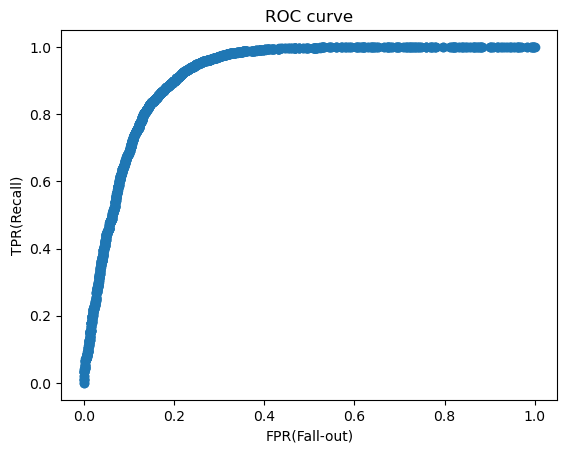

In [96]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [97]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val_os, y_pred_proba)
auc_score

0.9147456308542481

# 최종모델 선택
- RandomForest   
  - 하이퍼파라미터에 가중치를 주어 불균형한 타겟 class의 비율을 맞추는 모델 보다는 ADASYN을 이용한 up-sampling을 수행한 모델의 f1-score가 대체적으로 높아진 것을 확인할 수 있었다.
  - XGBoost, LightGBM은 과적합이 발생하여 제외시켰고, RandomForest 모델을 선택하였다.
  - 최종  RandomForest 모델의 f1-score 성능은 0.79이다.


In [98]:
print('RandomForest f1_score :', best_model_rf_sammpling.score(X_test_os, y_test_os))

RandomForest f1_score : 0.7351439435089625


In [99]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val_os, y_pred_proba)
auc_score

0.9147456308542481

# 특성중요도
- Feature Importances(Mean decrease impurity, MDI)
- 특성중요도  =  트리기반 모델의 불순도를 낮춰주는 특성을 알려주는 것 ( → 그만큼 중요한 특성임.)
- 하지만 카디널리티(high-cardinality)가 높은 특성이 특성중요도가 높게 나오는 경우 분기점이 많아지고 과적합을 주의 해야됨. 특성중요도 왜곡될 가능성 있다

In [100]:
# # 특성 중요도 데이터 프레임 생성
# importance = pipe_rf[1].feature_importances_
# feature = X_test_os.columns
# importances = pd.DataFrame()
# importances['feature'] = feature
# importances['importances'] = importance
# importances.sort_values('importances', ascending=False, inplace=True)
# importances.reset_index(drop=True, inplace=True)
# importances

# # 특성 중요도 시각화
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importances', y='feature', data=importances)
# plt.title('Random Forest Feature Importances', fontsize=18)
# plt.show()


- 순열중요도 (Permutation Importance, Mean Decrease Accuracy, MDA)


In [101]:
pipe_rf.fit(X_train_os, y_train_os)

permuter = PermutationImportance(
    pipe_rf.named_steps['randomforestclassifier'], # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_os, y_test_os);

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=X_val.columns.tolist()  # list 형식으로 넣어야 합니다
	)
     

Weight,Feature
0.0402 ± 0.0060,reality
0.0239 ± 0.0040,income_type
0.0235 ± 0.0034,car
0.0219 ± 0.0025,phone
0.0157 ± 0.0035,work_phone
0.0144 ± 0.0043,occyp_type
0.0131 ± 0.0021,gender
0.0116 ± 0.0013,email
0.0113 ± 0.0020,family_type
0.0085 ± 0.0018,career_year


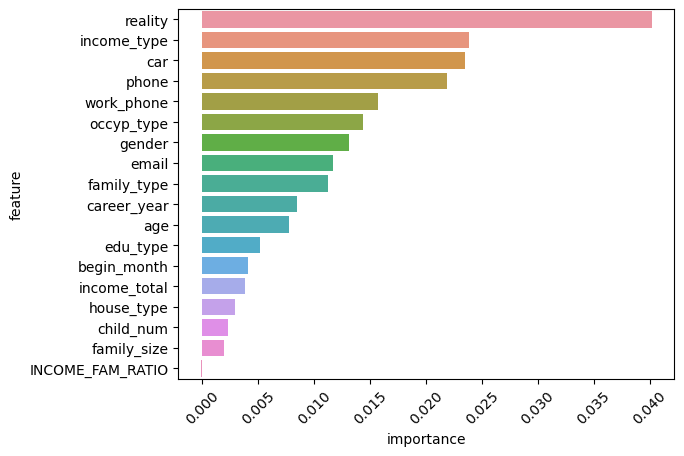

In [102]:
importances = pd.DataFrame({'feature' : X_test_os.columns,
                            'importance' : permuter.feature_importances_}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=importances)
plt.xticks(rotation=45);
     

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

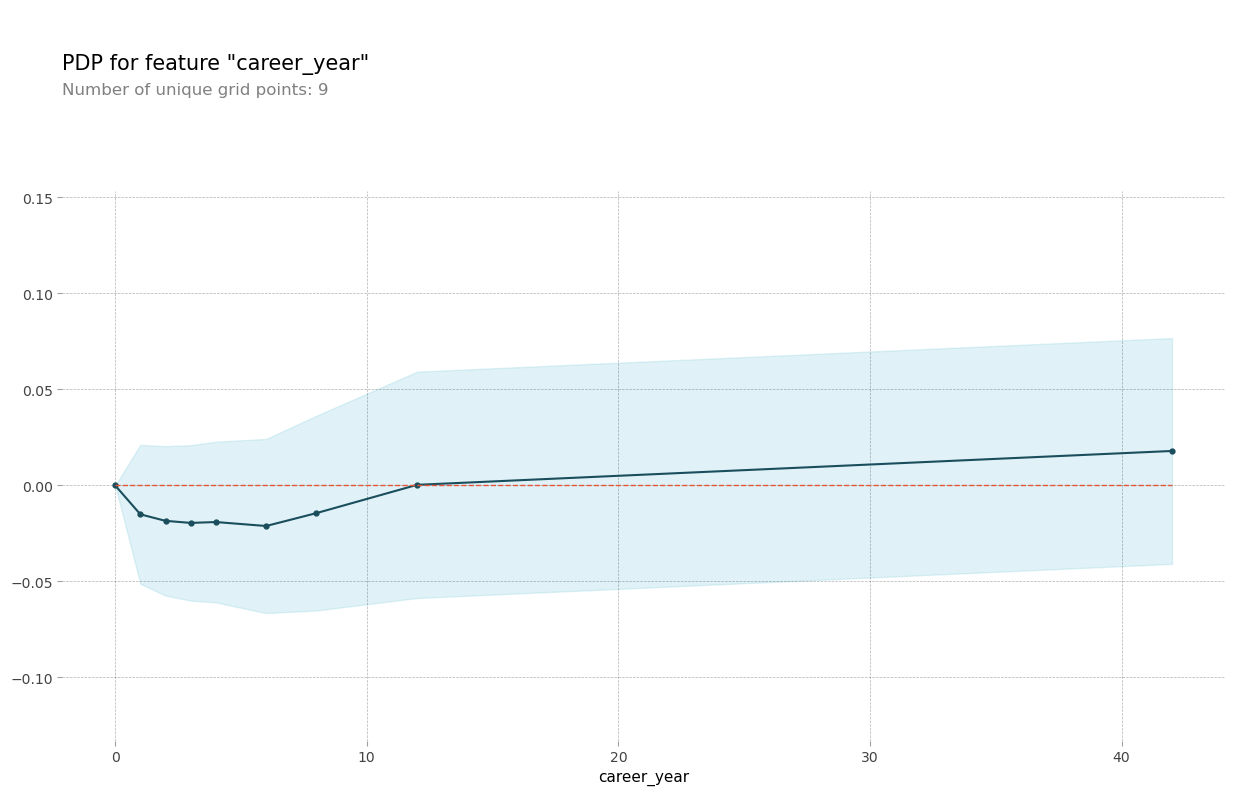

In [103]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# df['EMPLOYED_BIRTH_RATIO'] = df['career_year']/df['age']

feature = 'career_year'

isolated = pdp_isolate(
    model=best_model_rf_sammpling, 
    dataset=X_test_os, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

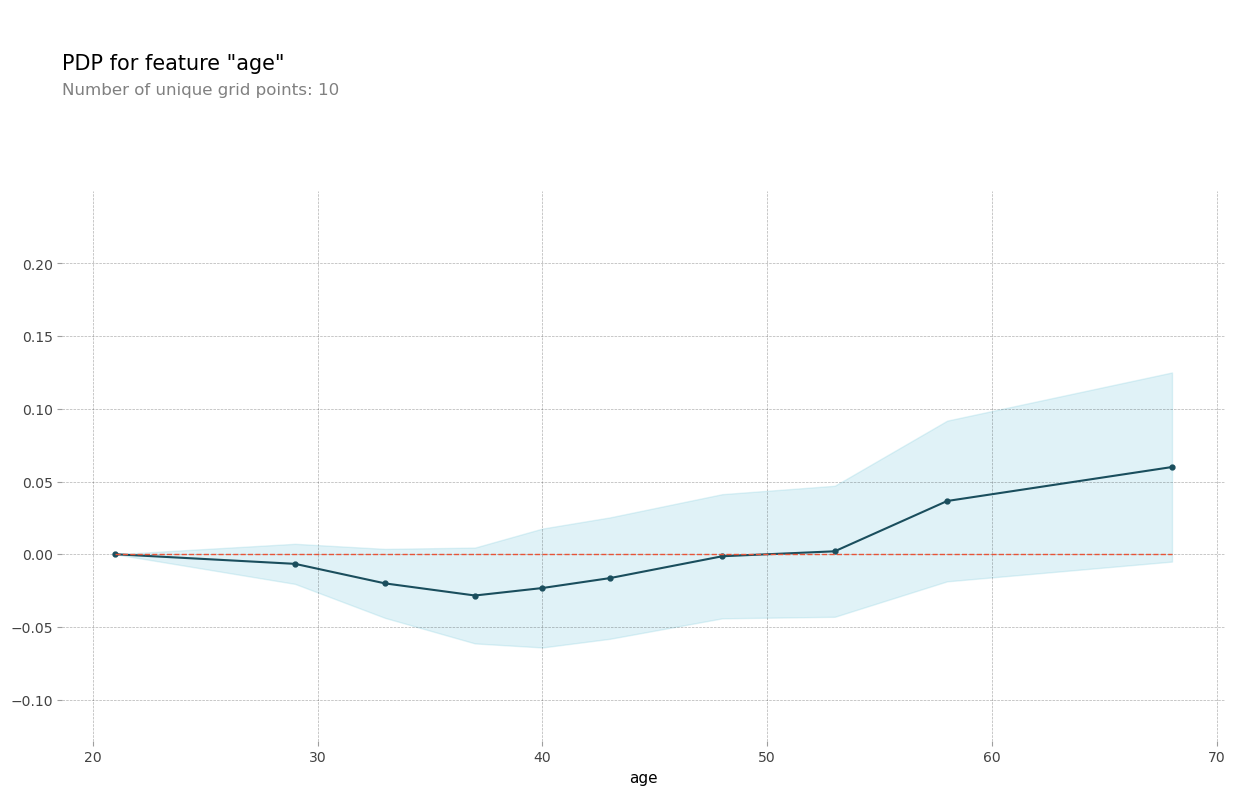

In [104]:
feature = 'age'

isolated = pdp_isolate(
    model=best_model_rf_sammpling, 
    dataset=X_test_os, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

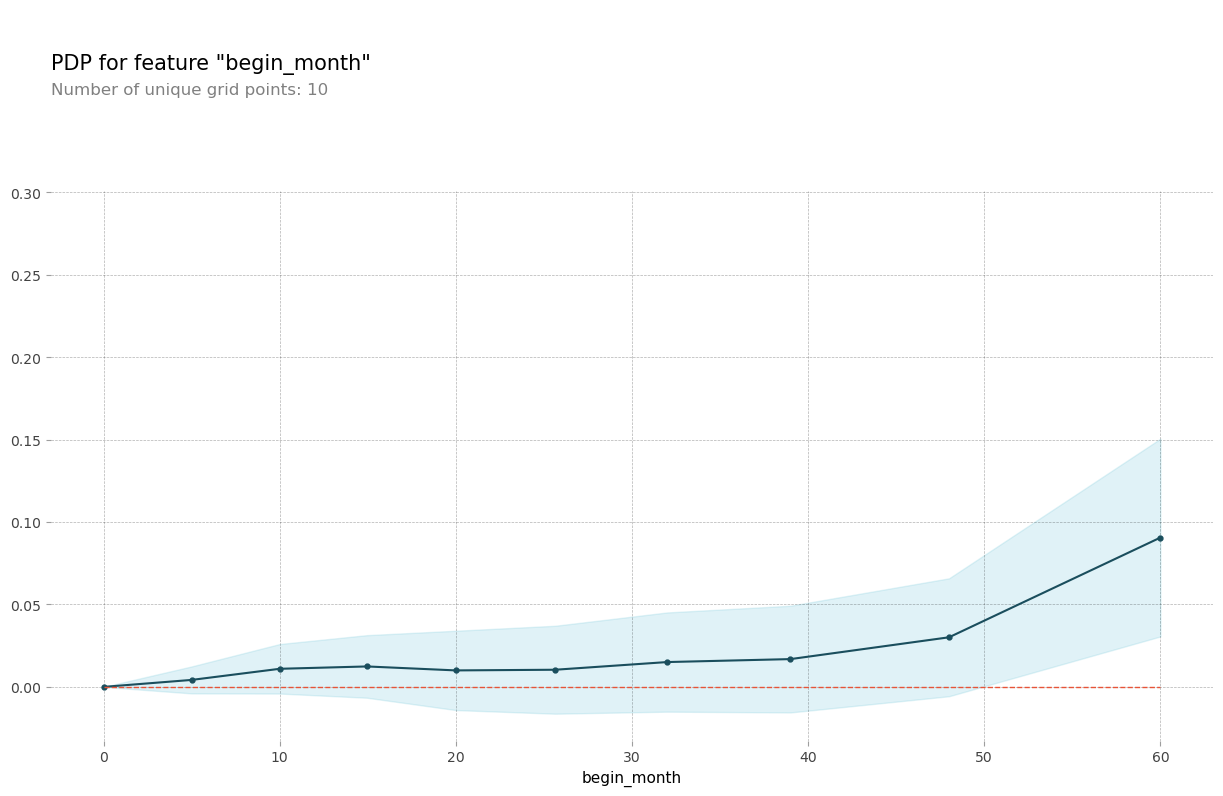

In [105]:

feature = 'begin_month'

isolated = pdp_isolate(
    model=best_model_rf_sammpling, 
    dataset=X_test_os, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

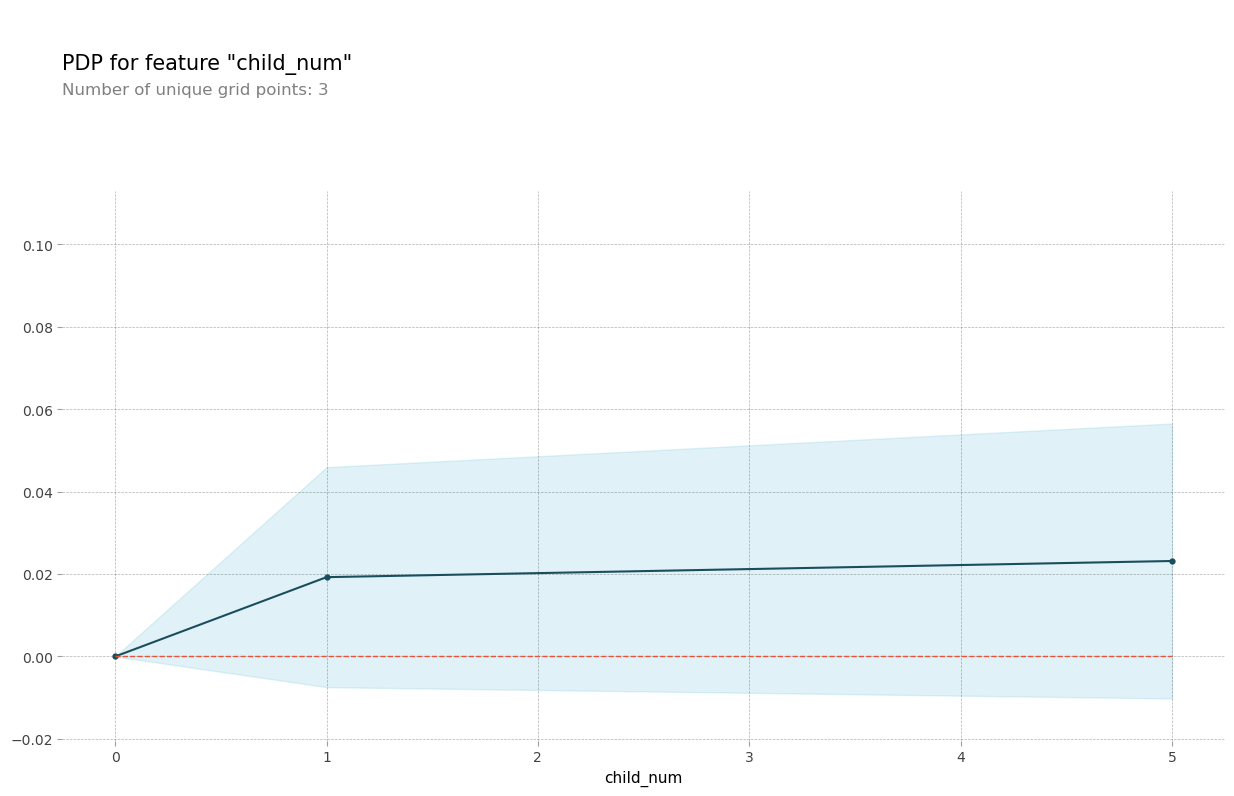

In [106]:
feature = 'child_num'

isolated = pdp_isolate(
    model=best_model_rf_sammpling, 
    dataset=X_test_os, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

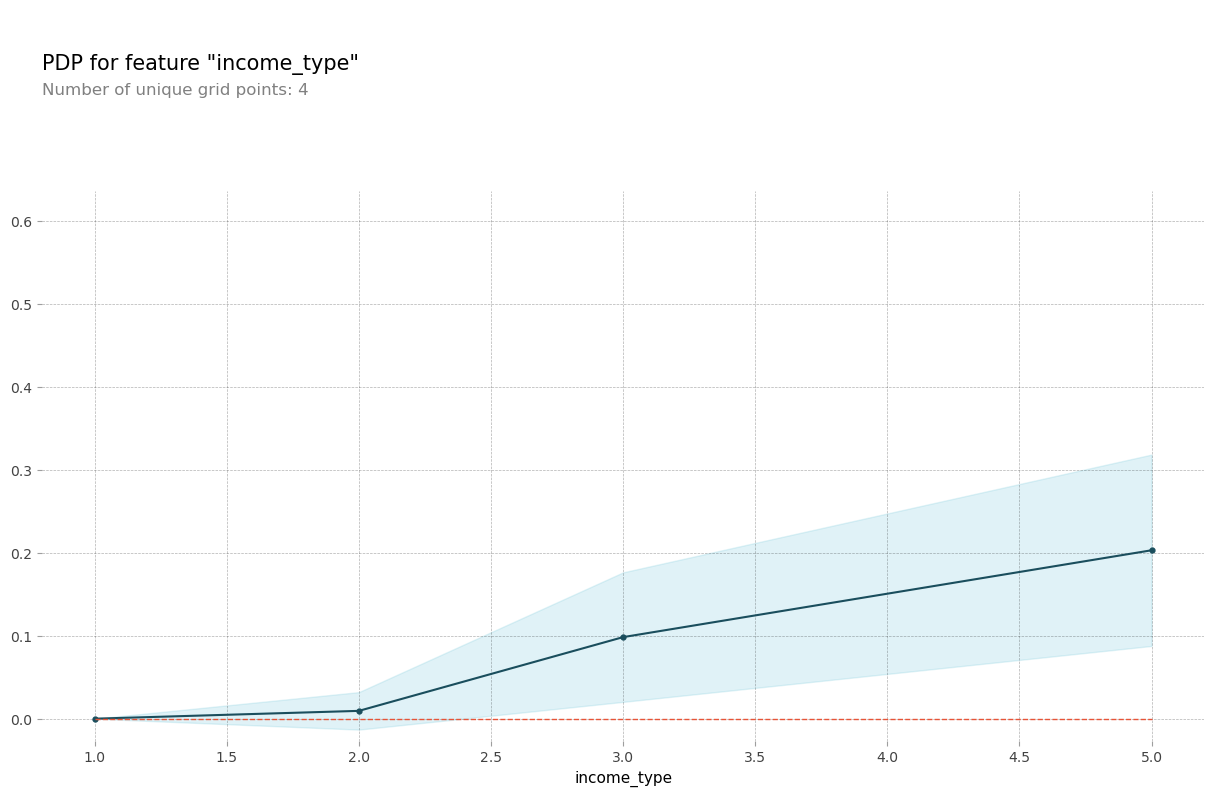

In [113]:

feature = 'income_type'

isolated = pdp_isolate(
    model=best_model_rf_sammpling, 
    dataset=X_test_os, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [114]:
df['income_type'].value_counts()


Working                 13639
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

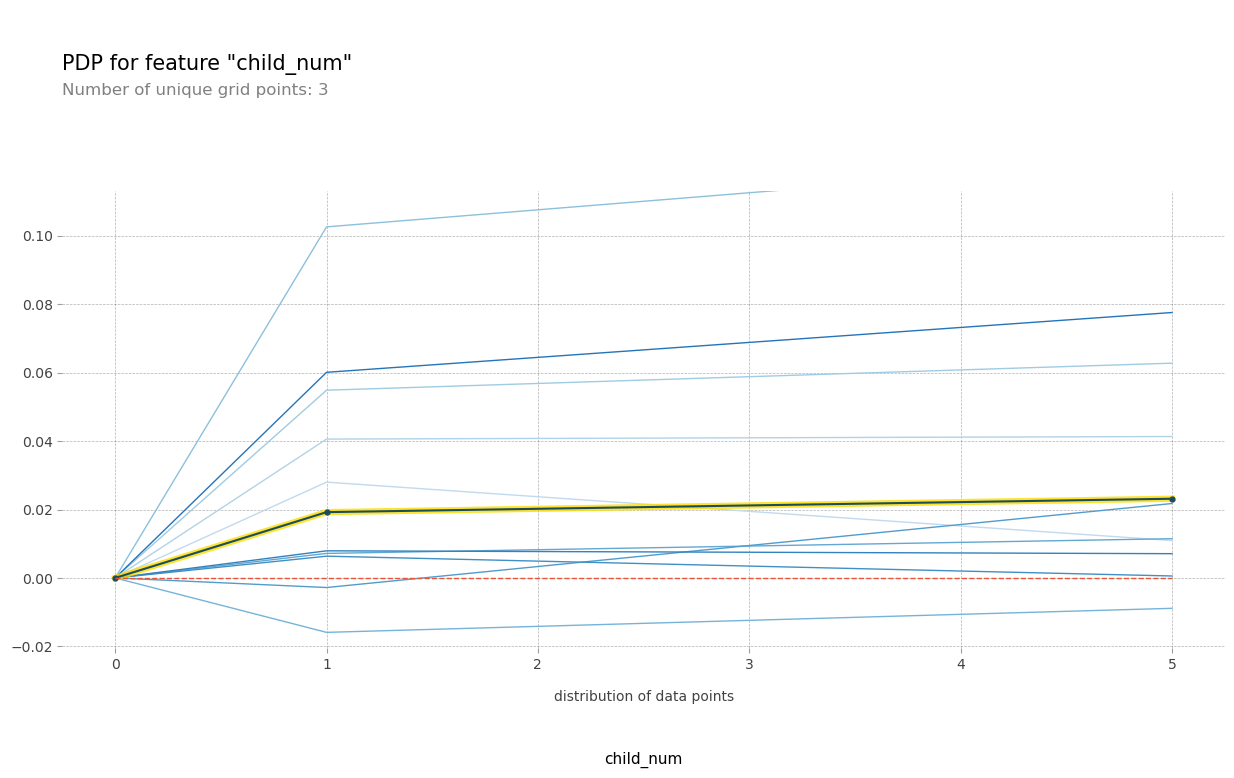

In [107]:

pdp_plot(isolated
         , feature_name="child_num"
         , plot_lines=True # ICE plots
         , frac_to_plot=10 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

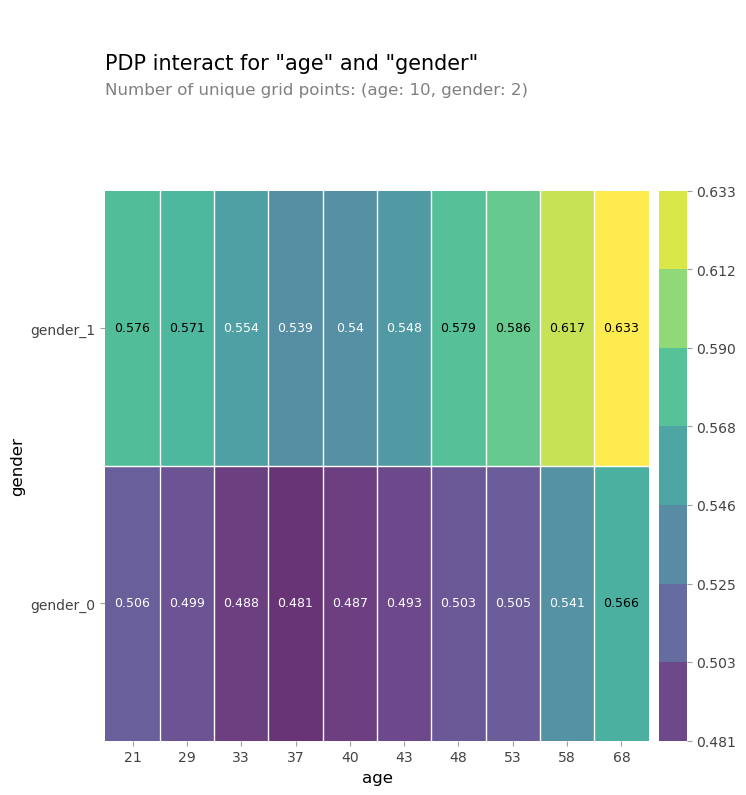

In [108]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['age', 'gender']

interaction = pdp_interact(
    model = clf_rf,
    dataset=X_test_os,
    model_features=X_test.columns, 
    features=features
)


pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

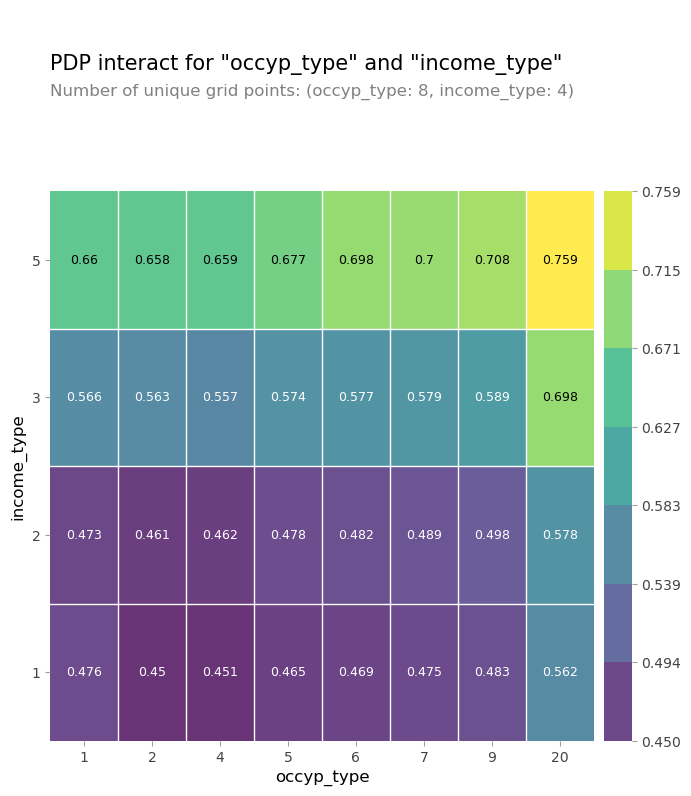

In [109]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['occyp_type', 'income_type']

interaction = pdp_interact(
    model = clf_rf,
    dataset=X_test_os,
    model_features=X_test.columns, 
    features=features
)


pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

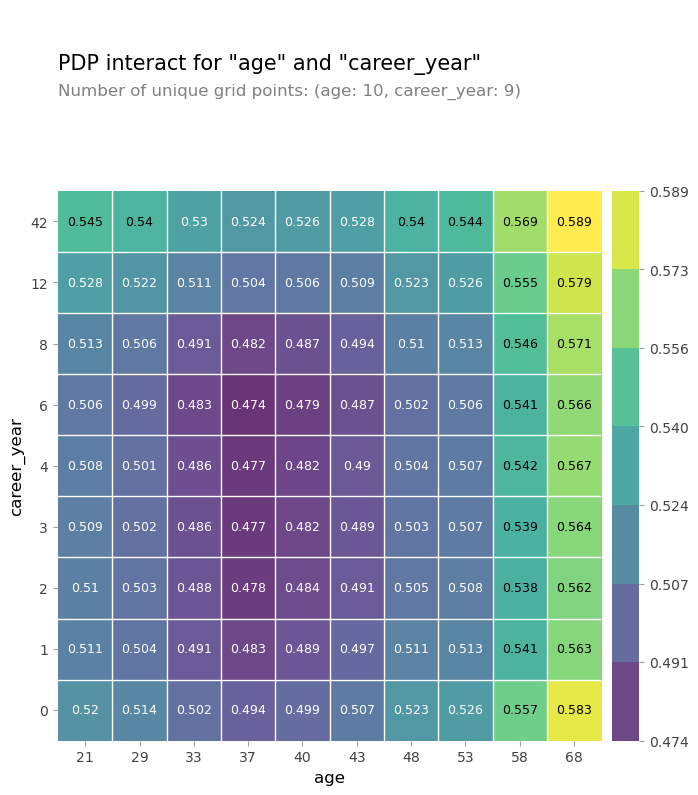

In [110]:
features = ['age', 'career_year']

interaction = pdp_interact(
    model = clf_rf,
    dataset=X_test_os,
    model_features=X_test.columns, 
    features=features
)


pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

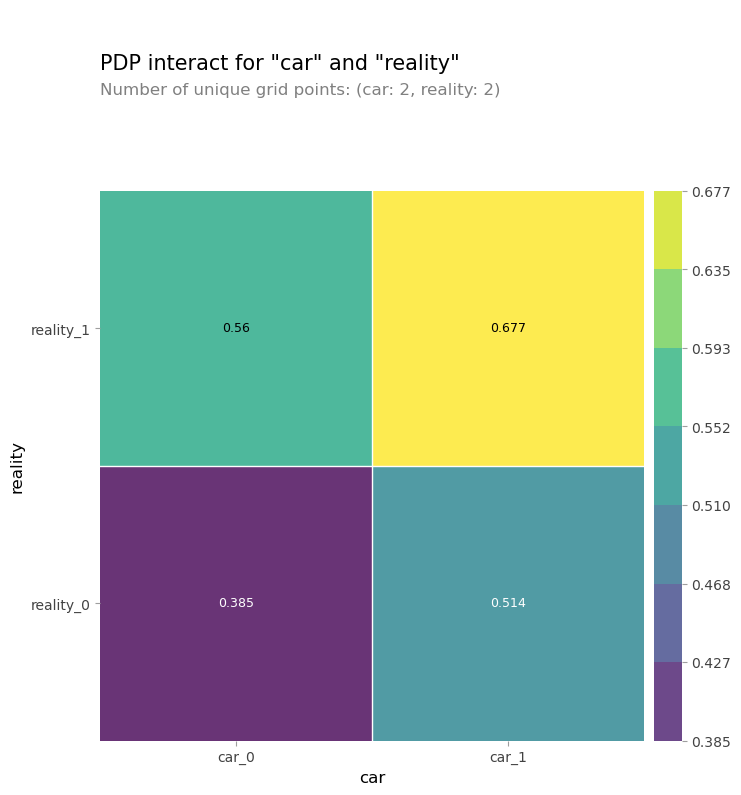

In [111]:
features = ['car', 'reality']

interaction = pdp_interact(
    model = clf_rf,
    dataset=X_test_os,
    model_features=X_test.columns, 
    features=features
)


pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

#### 부분의존도그림(Partial dependence plots, PDP)-> 관심있는 특성들이 타겟에 어떻게 영향을 주는지 쉽게 파악

In [112]:
# shap value를 이용하여 각 변수의 영향도 파악

!pip install shap # (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
import skimage  # -> skimage.__version__ (skimage version 확인)
# skimage version upgrade  # !pip install --upgrade scikit-image

# shap value 
import shap
explainer = shap.TreeExplainer(isolated) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'pdpbox.pdp.PDPIsolate'>

[LightGBM] [Warning] Unknown parameter: 92
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 60
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 39
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 42
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 18
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown parameter: 33
[LightGBM] [Warning] min_data_in_leaf is set=, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=
[LightGBM] [Warning] Unknown param